In [28]:
import networkx as nx
import numpy as np
import random
random.seed(42)
np.random.seed(42)
def normalize(X):
    X_min, X_max = X.min(), X.max()
    X_norm = 2 * (X - X_min) / (X_max - X_min) - 1
    return X_norm, X_min, X_max

def denormalize(X_norm, X_min, X_max):
    X_orig = (X_norm + 1) / 2 * (X_max - X_min) + X_min
    return X_orig

def overlap_accuracy_per_timestep(true_ids, pred_ids):
    assert true_ids.shape == pred_ids.shape
    true_ids = true_ids.T
    pred_ids = pred_ids.T
    n_targets, T = true_ids.shape
    acc_t = np.zeros(T, dtype=float)
    for t in range(T):
        true_set = set(true_ids[:, t].tolist())
        hits = sum((pred_ids[i, t] in true_set) for i in range(n_targets))
        acc_t[t] = hits / n_targets
    return acc_t, float(acc_t.mean())
    
def decode_topk(pred_array, n_targets):
    steps, n_nodes = pred_array.shape
    target_array_pred = np.zeros((steps, n_targets), dtype=int)

    for t in range(steps):
        topk_nodes = np.argsort(pred_array[t])[-n_targets:]  # 取最大值对应的节点
        target_array_pred[t, :] = topk_nodes  # 排序保证和真实结果一致性（可选）
    
    return target_array_pred

def simulate_dynamic_move(G, target_nodes_init, steps, move_prob=0.5,seed=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed) 
    G_attack = G.copy()
    n_nodes = G.number_of_nodes()
    target_nodes = list(target_nodes_init)
    n_targets = len(target_nodes)
    attacked_nodes = set()
    step = 0
    target_array = np.zeros((steps, n_targets), dtype=int)
    target_array_onehot = np.zeros((steps, n_nodes), dtype=int)

    while step < steps:
        new_target_nodes = [None] * n_targets
        occupied = set()
        for i, node in enumerate(target_nodes):
            if random.random() < move_prob:
                neighbors = list(G_attack.neighbors(node))
                candidates = [nbr for nbr in neighbors
                              if nbr not in attacked_nodes and nbr not in target_nodes and nbr not in occupied]
                if candidates:
                    new_node = random.choice(candidates)
                else:
                    new_node = node
            else:
                new_node = node
            new_target_nodes[i] = new_node
            occupied.add(new_node)
        target_nodes = new_target_nodes
        target_array[ step, :] = np.array(target_nodes, dtype=int)

        onehot = np.zeros(n_nodes, dtype=int)
        onehot[target_nodes] = 1
        target_array_onehot[step, :] = onehot
        step += 1
    return target_array, target_array_onehot
n = 100
# G = nx.barabasi_albert_graph(n, 4, seed=42)
G = nx.watts_strogatz_graph(n, 8, 0.1, seed=42)
target_num = int(n * 0.05)
target_nodes_random = random.sample(list(G.nodes()), target_num)
X,X_onehot = simulate_dynamic_move(G, target_nodes_random, steps=20096,seed=42)
X_1 = X[:,0]
print(X_1.shape)

(20096,)


[ 3 35 19 81 98]
[81 19  3 98 35]
20096


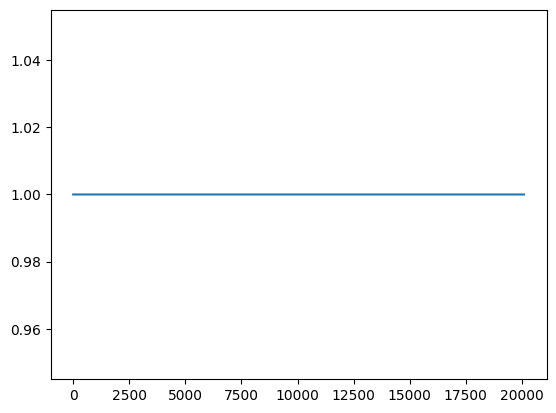

In [3]:
import matplotlib.pyplot as plt
X_norm, X_min, X_max = normalize(X)
X_deonehot = decode_topk(X_onehot, target_num)
print(X_deonehot[1])
print(X[1])
#X_denorm = denormalize(X_norm, X_min, X_max)
#X_denorm = np.rint(X_denorm).astype(int)
acc_x, acc_mean = overlap_accuracy_per_timestep(X, X_deonehot)
print(len(acc_x))
plt.figure()
plt.plot(np.arange(acc_x.size), acc_x)
#plt.plot(np.arange(acc_x.size), acc_x)
#plt.plot(X_norm[:500,0])
#plt.plot(X_onehot[:500,0])
#plt.plot(X_norm[:,1])
#plt.plot(X_norm[:,2])
#plt.plot(X_norm[:,3])
#plt.plot(X_norm[:,4])

In [4]:
from reservoirpy.observables import nrmse, rsquare
# Objective functions accepted by ReservoirPy must respect some conventions:
#  - dataset and config arguments are mandatory, like the empty '*' expression.
#  - all parameters that will be used during the search must be placed after the *.
#  - the function must return a dict with at least a 'loss' key containing the result of the loss function.
# You can add any additional metrics or information with other keys in the dict. See hyperopt documentation for more informations.
def objective(dataset, config, *, input_scaling, N, sr, lr, ridge, seed, connectivity):
    # This step may vary depending on what you put inside 'dataset'
    x_train, x_test, y_train, y_test = dataset
    
    # You can access anything you put in the config file from the 'config' parameter.
    instances = config["instances_per_trial"]
    
    # The seed should be changed across the instances to be sure there is no bias in the results due to initialization.
    variable_seed = seed 
    
    losses = []; r2s = [];
    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(
            units=N, 
            sr=sr, 
            lr=lr, 
            input_scaling=input_scaling, 
            rc_connectivity=connectivity,
            seed=variable_seed
        )

        readout = Ridge(ridge=ridge)

        model = reservoir >> readout


        # Train your model and test your model.
        predictions = model.fit(x_train, y_train) \
                           .run(x_test)
        
        loss = nrmse(y_test, predictions, norm_value=np.ptp(x_train))
        r2 = rsquare(y_test, predictions)
        
        # Change the seed between instances
        variable_seed += 1
        
        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}

In [5]:
import json
hyperopt_config = {
    "exp": "hyperopt-multiscroll",    # the experimentation name
    "hp_max_evals": 10,              # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",            # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                       # the random state seed, to ensure reproducibility
    "instances_per_trial": 1,         # how many random ESN will be tried with each sets of parameters
    "hp_space": {                     # what are the ranges of parameters explored
        "N": ["choice", 1000],             # the number of neurons is fixed to 500
        "sr": ["loguniform", 1e-2, 10],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["loguniform", 1e-3, 1],    # idem with the leaking rate, from 1e-3 to 1
        "input_scaling": ["choice", 1.0], # the input scaling is fixed
        "ridge": ["loguniform", 1e-8, 1e-1],        # and so is the regularization parameter.
        "connectivity":["loguniform", 0.01, 1],
        "seed": ["choice", 1234]          # an other random seed for the ESN initialization
    }
}

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

In [22]:
from reservoirpy.datasets import to_forecasting
train_len = 16000
forecast = 1
X_train = X_onehot[:train_len]
Y_train = X_onehot[forecast : train_len + forecast]

X_test = X_onehot[train_len : -forecast]
Y_test = X_onehot[train_len + forecast:]
print(Y_test[0])
dataset = (X_train, X_test, Y_train, Y_test)
print(len(X_train))
print(len(X_test))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0]
16000
4095


In [7]:
from reservoirpy.hyper import parallel_research
from reservoirpy.nodes import Reservoir, Ridge
best = parallel_research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")

100%|██████████| 10/10 [06:25<00:00, 38.59s/trial, best loss=0.215]


In [16]:
print(best)

({'N': 1000, 'sr': np.float64(0.019166024706981727), 'lr': np.float64(0.845020130213906), 'input_scaling': 1.0, 'ridge': np.float64(0.0021280308221173134), 'connectivity': np.float64(0.37336070725030324), 'seed': 1234}, np.float64(0.2150037707323787))


In [23]:
units = 1000
leak_rate = 0.945020130213906
spectral_radius = 0.019166024706981727
input_scaling = 1.0
connectivity = 0.37336070725030324
regularization = 0.0021280308221173134
seed = 1234
from reservoirpy.nodes import Reservoir, Ridge

reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,seed=seed)

readout   = Ridge(ridge=regularization, output_dim=100)

esn = reservoir >> readout

In [25]:
esn = esn.fit(X_train, Y_train)

(4095, 100)
(4095, 100)


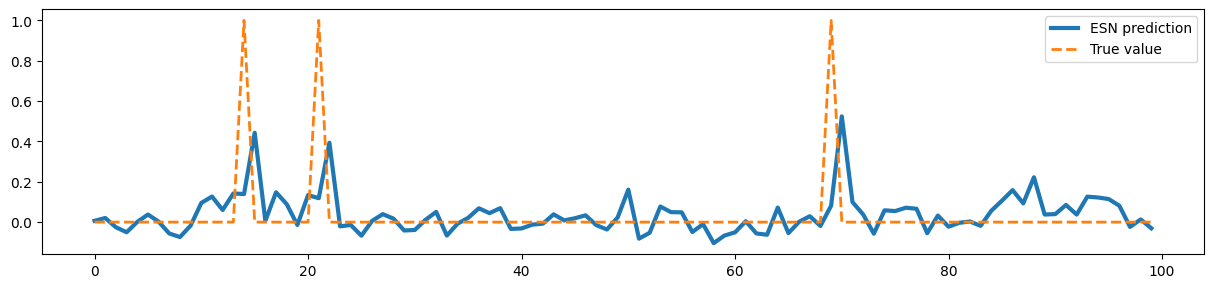

In [26]:
def plot_results(y_pred, y_test):

    fig = plt.figure(figsize=(15, 7))
    plt.subplot(211)
    plt.plot(np.arange(len(y_pred[:100,0])), y_pred[:100,0], lw=3, label="ESN prediction")
    plt.plot(np.arange(len(y_test[:100,0])), y_test[:100,0], linestyle="--", lw=2, label="True value")
    #plt.plot(np.abs(y_test[:100,0] - y_pred[:100,0]), label="Absolute deviation")

    plt.legend()
    plt.show()
y_pred = esn.run(X_test)

print(y_pred.shape)
print(Y_test.shape)
plot_results(y_pred, Y_test)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
[31 43 46 74 73]
[35 71 31 46 74]
4094


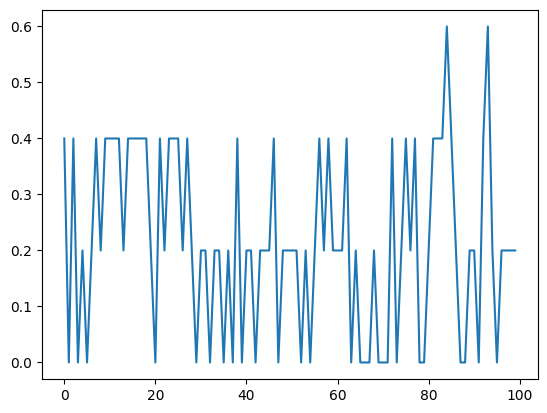

In [21]:
print(Y_test[0])
Y_test1 = decode_topk(Y_test, target_num)
y_pred1 = decode_topk(y_pred, target_num)
print(Y_test1[97])
print(y_pred1[98])
acc_t, acc_mean = overlap_accuracy_per_timestep(Y_test1, y_pred1)
print(len(acc_t))
plt.figure()
plt.plot(np.arange(acc_t[:100].size), acc_t[:100])